In [38]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import json

# Load the Data 

In [39]:
df = pd.read_csv('..\data\playDataProd.csv', index_col=0).reset_index()

In [40]:
df.head()

,game_id,period,eventIdx,season,game_type,start_time,end_time,away_team_id,away_team_name,home_team_id,...,Assist_last,Scorer,Goalie,Shooter,home_rinkSide,away_rinkSide,rinkSide,x_goal,y_goal,shot_distance
0,2016020001,2,174,20162017,R,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,10,Toronto Maple Leafs,9,...,NaN,NaN,Craig Anderson,William Nylander,right,left,left,89,0,49.193496
1,2016020001,2,213,20162017,R,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,10,Toronto Maple Leafs,9,...,NaN,NaN,Craig Anderson,Nikita Zaitsev,right,left,left,89,0,64.884513
2,2016020001,2,228,20162017,R,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,10,Toronto Maple Leafs,9,...,NaN,NaN,Craig Anderson,James van Riemsdyk,right,left,left,89,0,33.241540
3,2016020001,2,239,20162017,R,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,10,Toronto Maple Leafs,9,...,Jake Gardiner,Auston Matthews,Craig Anderson,NaN,right,left,left,89,0,8.944272
4,2016020001,3,301,20162017,R,2016-10-12T23:00:00Z,2016-10-13T01:56:40Z,10,Toronto Maple Leafs,9,...,NaN,NaN,Craig Anderson,Morgan Rielly,left,right,right,-89,0,57.218878


Take a look at the ice hocky rink dimensions: 
The x coordinate is in the range $[-100, 100]$ ft, 
The y coordinate is in the range $[-42.5, +42.5]$ ft. 

Since we are only look at the offensive zone, and we don't conside the shots behind the net we confine our x_coordinate range in $[0, 89]$. Note that the goal line is 11 ft from the boarders. Therefore, we compute the shot rates that are in the range [0, 89]. For the visualization part, we focus on $x\in [0, 90]$ and $y\in [-40, 40]$ as shown in the project milestone. 

![](Ice_hockey_layout.png)

Another point is that since in each period, players change their net side, and we want to compare each team to the whole league, we flipp all shots with negative `x_coordinate` so that all of the shots are taken place at the positive side of the rink which we want to display. 

Note that we could have just flipped the `x_coordinate` of the second periods to make sure each team maintains their net side. However, since we want to calculate the mean shot and compare it a specific team, this is not fair. 


[source of the figure: Wikipedia](https://en.wikipedia.org/wiki/Ice_hockey_rink)

In [41]:
def XYCoordinateModification(df:pd.DataFrame): 
    """
    Modifies the x_coordinate and y_coordinate to adjust to our problem 
    """
    # flipp all rows in which the x_coordinate is negative 
    df_copy = df.copy() 
    condition = df['x_coordinate'] < 0 
    df.loc[condition, ['x_coordinate', 'y_coordinate']] *= -1

    # remove those shots behind the net: shots with x_coordinate bigger than (100-11)=89 
    behind_net = df['x_coordinate'] > 89 
    df = df.drop(df[behind_net].index) 
    
    # in the originial rink: the net is place at 89 and the center is placed at 0. 
    # but for visualization according to the milestone, we want to plot the rink such that the net is placed at 0 and the center at 89. 
    # therefore we shift all x_coordinates 89 steps back 
    df['x_coordinate'] = abs(df['x_coordinate'] - 89)
    return df 

In [42]:
dfa = XYCoordinateModification(df)
dfa.head()[['x_coordinate', 'y_coordinate']]

,x_coordinate,y_coordinate
0,44.0,-22.0
1,57.0,-31.0
2,32.0,9.0
3,8.0,4.0
4,57.0,-5.0


# Average Shot Rate per hour

In [43]:
def ShotRate(df:pd.DataFrame): 
    """
    Computes the shot rate for a given dataframe. 
    """
    total_games = df['game_id'].nunique() # how many games played in the season? 
    df = df.groupby(['x_coordinate', 'y_coordinate']).count() # count how many shots per x and y loc as a group 
    shot_rate_df = pd.DataFrame(df.iloc[:, 0])  # convert the result to a dataframe 
    shot_rate_df = shot_rate_df.rename(columns = {'game_id':'shot_rate'}) # pick the first column (all same) and rename the colname as shot_rate (counts) 
    shot_rate_df['shot_rate'] /= total_games # divide the counts by the total games played in the season 
    # print(shot_rate_df)
    return shot_rate_df 

In [44]:
def ExcessRate(team:str, season:int, df:pd.DataFrame):
    """
    Computes the excess shot rate for a given team and a season. 
    """
    df_temp = df.copy()
    df_temp = df_temp[df_temp['season']==season] # filter based on season 
    shot_rate_df = ShotRate(df_temp) * 0.5 
    df_temp = df_temp[(df_temp['team_name'] == team)] # filter the games the team played
    shot_rate_team_df = ShotRate(df_temp)
    # we choose to subtract the shot rate of team from the league, because for percentage it gets tricky if there is a zero in the shot_rat_df 
    excess = shot_rate_team_df.sub(shot_rate_df, fill_value = 0)
    return excess

In [45]:
def SmoothOut(team:str, season:int, dfa:pd.DataFrame, variance = 6):
    """
    Smoothes out the sharp edges of the contours using kernel density estimation 
    """
    df_rate = ExcessRate(team_name, season, dfa)
    # print(df_rate)
    df_rate = df_rate.reset_index()
    x_grid = np.linspace(0, 90, 91)
    y_grid = np.linspace(-40, 40, 81)
    [x, y] = np.round(np.meshgrid(x_grid, y_grid))
    z = griddata((df_rate['x_coordinate'], df_rate['y_coordinate']), df_rate['shot_rate'], (x,y), method='cubic', fill_value=0)
    z = pd.DataFrame(z) * 100
    z_smooth = gaussian_filter(z, sigma = variance)
    return z_smooth, x, y 

In [46]:
def PlotShotMap(team_name:str, season:int, z_smooth:np.array, x:np.array, y:np.array): 
    """
    Plots the shot map for a given team, season, the smoothen out excess shot rate for that team. 
    """
    # z_smooth, x, y = SmoothOut(team_name, season, dfa) 
    plt.figure(figsize = [12, 8])
    plt.contourf(x, y, z_smooth, alpha = 0.7, cmap='bwr', levels = np.linspace(-1,1,20), vmin=-1, vmax=1) 
    plt.colorbar(orientation = "horizontal").set_label('Excess Shot Rate per hour')
    plt.xlabel('Distance from the center of the rink (ft)')
    plt.ylabel('Distance from the Goal Line (ft)') 
    plt.title(f'Excess Shot Rate per hour for {team_name} in season {season}')
    plt.show() 

# Example

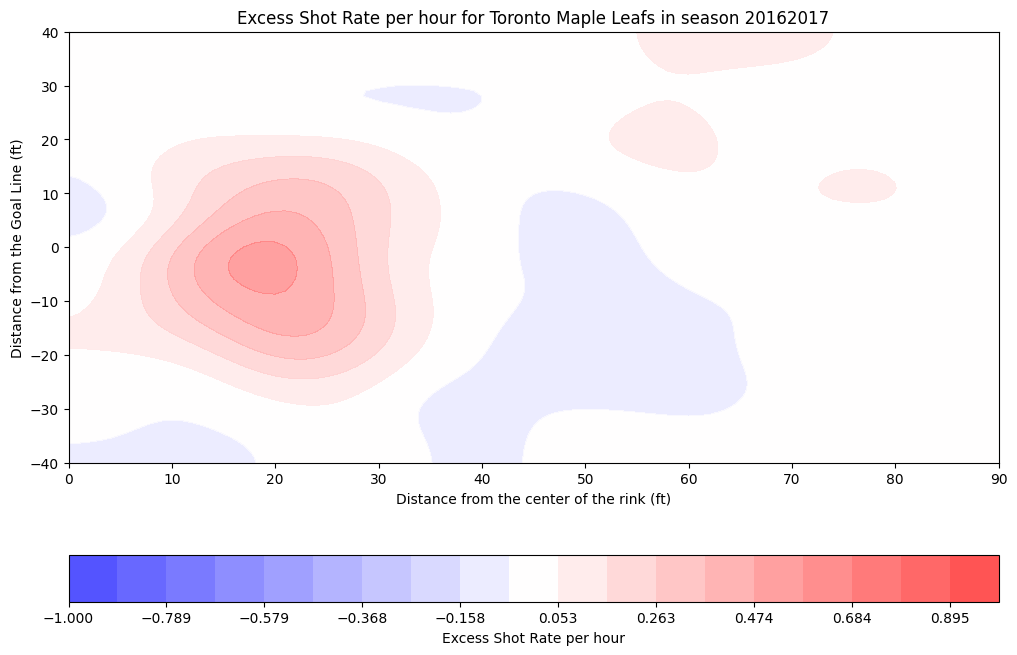

In [47]:
season = 20162017 
team_name = 'Toronto Maple Leafs'
z_smooth, x, y = SmoothOut(team_name, season, dfa)
PlotShotMap(team_name, season, z_smooth, x, y)

# Save Data For all seasons 

In [48]:
# def ShotTeamGroup(df_group, shot_all):
#     df_temp = df.copy()
#     # we choose to subtract the shot rate of team from the league, because for percentage it gets tricky if there is a zero in the shot_rat_df 
#     excess = shot_rate_team_df.sub(shot_all, fill_value = 0)
#     return excess

In [49]:
def ShotRateGroup(df_group:pd.DataFrame)-> pd.DataFrame: 
    """
    Computes the shot rate for each group
    """
    df = df_group.copy() 
    total_games = df['game_id'].nunique() # how many games played in the season? 
    df = df.groupby(['x_coordinate', 'y_coordinate']).count() # count how many shots per x and y loc as a group 
    shot_rate_df = pd.DataFrame(df.iloc[:, 0])  # convert the result to a dataframe 
    shot_rate_df = shot_rate_df.rename(columns = {'game_id':'shot_rate'}) # pick the first column (all same) and rename the colname as shot_rate (counts) 
    shot_rate_df['shot_rate'] /= total_games # divide the counts by the total games played in the season 
    return shot_rate_df 

In [50]:
def Smoother(df_rate:pd.DataFrame, variance = 5):
    """
    smoothes out the computed excess shot rate 
    """
    df_rate = df_rate.reset_index()
    x_grid = np.linspace(0, 90, 91)
    y_grid = np.linspace(-40, 40, 81)
    [x, y] = np.round(np.meshgrid(x_grid, y_grid))
    z = griddata((df_rate['x_coordinate'], df_rate['y_coordinate']), df_rate['shot_rate'], (x,y), method='cubic', fill_value=0)
    z = pd.DataFrame(z) * 100
    z_smooth = gaussian_filter(z, sigma = variance)
    return z_smooth

In [51]:
def save_to_json(pattern, file_path):
    """
    Save the dictionary into a json file. The values of the dictionary are numpy arrays.
    """
    pattern_serializable = {key: value.tolist() for key, value in pattern.items()}
    with open(file_path, 'w') as json_file:
        json.dump(pattern_serializable, json_file)

In [52]:
def load_from_json(file_path):
    """
    Loads the json file into the memory. Transforms back the json file into a dictionary with a desired pattern. 
    """
    with open(file_path, 'r') as json_file:
        loaded_data = json.load(json_file)
    loaded_pattern = {key: np.array(value) for key, value in loaded_data.items()}
    return loaded_pattern

In [53]:
Excess = lambda team_rate, league_rate: team_rate.sub(league_rate, fill_value = 0) # difference of average shot rate for a team and the league 

In [54]:
avg_shot_rates = 0.5 * dfa.groupby(['season']).apply(ShotRateGroup) # compute average shot rate for each season 

In [55]:
all_seasons = [20162017, 20172018, 20182019, 20192020, 20202021]
all_season_shot_rate = {season: [] for season in all_seasons}

In [56]:
for season in all_season_shot_rate: 
    all_season_shot_rate[season] = avg_shot_rates.loc[season] # storing all average shot rates in a dictionary 

## season

In [58]:
season = 20172018
shot_all = all_season_shot_rate[season]
dfb = dfa[dfa['season'] == season] 
team_names = dfb['team_name'].unique() 
team_shots = dfb.groupby('team_name').apply(ShotRateGroup)
excess  = {name: Excess(team_shots.loc[name], shot_all) for name in team_names}
excess_smooth = {name:Smoother(excess[name]) for name in team_names} # smooth out the excess shot rate for each team playing in the season 

In [59]:
save_to_json(excess_smooth, '../data/excess_20172018_smooth')

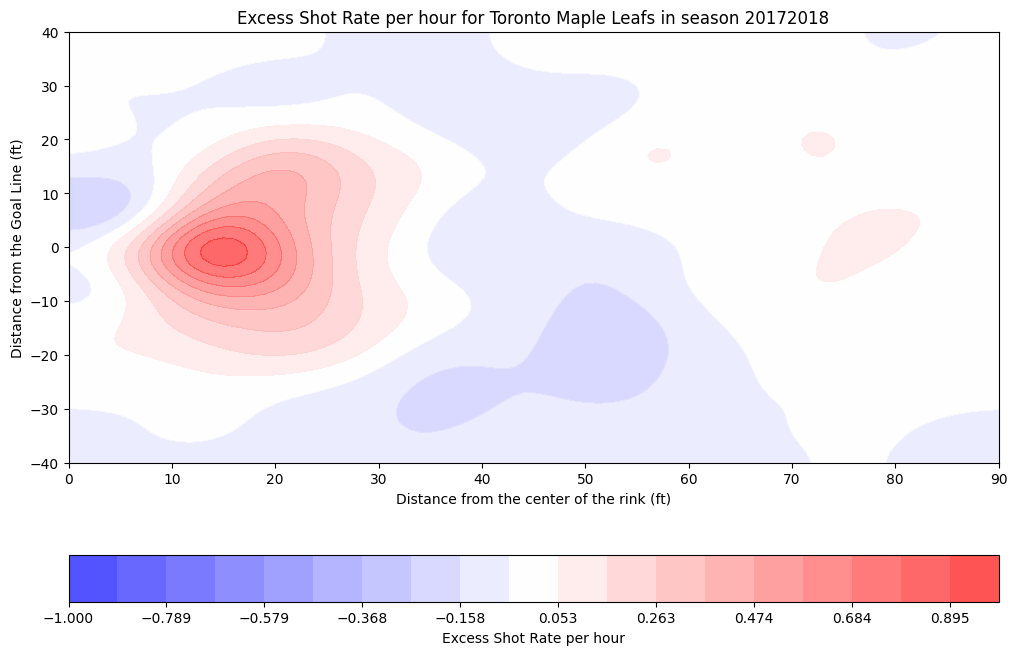

In [61]:
# Example
season = 20172018
z = excess_smooth['Toronto Maple Leafs']
x_grid = np.linspace(0, 90, 91)
y_grid = np.linspace(-40, 40, 81)
[x, y] = np.round(np.meshgrid(x_grid, y_grid))
plt.figure(figsize = [12, 8])
plt.contourf(x, y, z, alpha = 0.7, cmap='bwr', levels = np.linspace(-1,1,20), vmin=-1, vmax=1) 
plt.colorbar(orientation = "horizontal").set_label('Excess Shot Rate per hour')
plt.xlabel('Distance from the center of the rink (ft)')
plt.ylabel('Distance from the Goal Line (ft)') 
plt.title(f'Excess Shot Rate per hour for {team_name} in season {season}')
plt.show() 

In [62]:
np.save('../data/x.npy', x)
np.save('../data/y.npy', y)

In [63]:
def ShotRateExcessAll(season:int, all_season_shot_rate:dict, loc_name): 
    shot_all = all_season_shot_rate[season] # retrieve the average shot rate for the given season 
    dfb = dfa[dfa['season'] == season]  # filter out the season 
    team_names = dfb['team_name'].unique() # unique team names 
    team_shots = dfb.groupby('team_name').apply(ShotRateGroup) # average shot rate for each team in the season 
    excess = {name: Excess(team_shots.loc[name], shot_all) for name in team_names} # difference 
    excess_smooth = {name:Smoother(excess[name]) for name in team_names} # smooth out 
    save_to_json(excess_smooth, loc_name)
    print(f'season {season} done!')

In [64]:
for season in all_seasons: 
    loc_name = '../data/excess_{}.json'.format(season) # file loaction 
    ShotRateExcessAll(season=season, all_season_shot_rate=all_season_shot_rate, loc_name=loc_name) # save excess shot rates for each season 

season 20162017 done!
season 20172018 done!
season 20182019 done!
season 20192020 done!
season 20202021 done!


# Plot from memory 

In [65]:
x = np.load('../data/x.npy')
y = np.load('../data/y.npy')

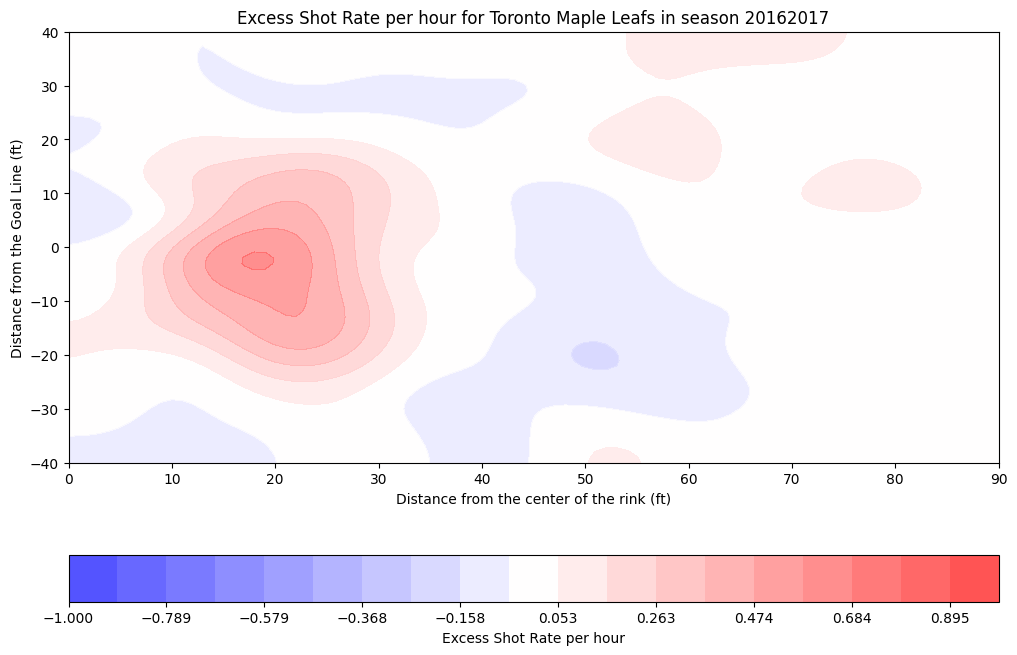

In [66]:
season = 20162017
loc = '../data/excess_{}.json'.format(season)
E = load_from_json(loc)
z = E['Toronto Maple Leafs']
plt.figure(figsize = [12, 8])
plt.contourf(x, y, z, alpha = 0.7, cmap='bwr', levels = np.linspace(-1,1,20), vmin=-1, vmax=1) 
plt.colorbar(orientation = "horizontal").set_label('Excess Shot Rate per hour')
plt.xlabel('Distance from the center of the rink (ft)')
plt.ylabel('Distance from the Goal Line (ft)') 
plt.title(f'Excess Shot Rate per hour for {team_name} in season {season}')
plt.savefig(f'Excess Shot Rate per hour for {team_name} in season {season}.png')
plt.show() 

# Questions

In [67]:
# *Discuss (in a few sentences) what you can interpret from these plots* 

# **Answer**
# The plot show how much a given team has more or less shots compared to the entire league in each location (levels in the contour map). For example: 
# - If the level is between $[0.6, 0.8]$ and its color is x, it reflects that the given team has more shots compared to the leauge in that x colored region.

# - If the level is between $[-0.6, -0.5]$ and its color is xx, it reflects that the given team has less shots compared to the leauge in that xx colored region.
# - The white areas are those that both the team and league are shooting the same number of shots on average. 
# ----

## Question 6.2

*Discuss (in a few sentences) what you can interpret from these plots* 

**Answer**

The plot show how much a given team has more or less shots compared to the entire league in each location (levels in the contour map). For example: 

- The red areas show the regions where the team did more shots compared to the league on average. The higher intensity of the color, the higher difference is. 
- The blue areas show the regions where the team did less shots compared to the league on average. The higher intensity of the color, the higher difference is. 
- The white areas are those that both the team and league are shooting the same number of shots on average. 

## Question 6.3

*Consider the Colorado Avalanche; take a look at their shot map during the 2016-17
season. Discuss what you could say about the team during this season. Now look at the
shot map for the Colorado Avalanche for the 2020-21 season, and discuss what you
could conclude from these differences. Does this make sense? Hint: look at the
standings.*

**Answer** 

It seems that Colorado Avalanche has progress
ed a lot through time. In 20162017, they are below the average on most parts of the offensive zone. However, on 20202021, they are mostly above the average on most parts of the offensive zone. 

Taking a look at the standings, reveals, they had climbed up the ladder throght time. For our own analysis, we also compare the number of goals they had with other teams in these two seasons. This also reveals their progress. They are have the lowest number of goals in 20162017 in total compared to all other teams, while in 20202021, they are among the top teams in terms of total goals in the season. 

In 20162017, the their strategy was to shot from the boarders either from close or far distance from the net. However, this was successful, so their strategy changed to shooting from the mid way infront of their oppenent's net. 

In [68]:
vcount = lambda COL, value: (COL['strength'] == value).sum()

In [69]:
team = 'Colorado Avalanche' 

condition_a = ((dfa['team_name']==team) & (dfa['season']==20162017)) 
condition_b = ((dfa['team_name']==team) & (dfa['season']==20202021))

In [70]:
dxx = dfa[condition_a]
dyy = dfa[condition_b]
types = ['EVEN', 'PPG', 'SGG']
sx = [vcount(dxx, n) for n in types]
sy = [vcount(dyy, n) for n in types]
print(sx) 
print(sy) 

[132, 30, 0]
[149, 46, 0]


In [71]:
def count_goals(group): 
    return (group['is_goal'] == True).sum()

In [72]:
goals = dfa.groupby(['season', 'team_name']).apply(count_goals) 

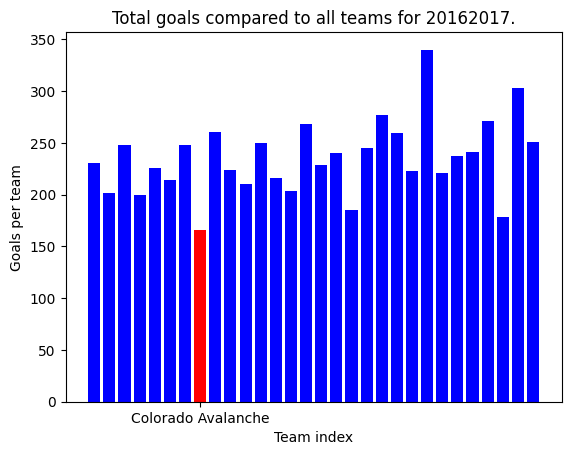

In [73]:
index = goals.loc[20162017].index
a = np.where(goals.loc[20162017].index==team)[0][0]
colors = ['blue' if i != 7 else 'red' for i in range(len(index))]
count_goals = goals.loc[20162017].values
plt.bar(range(len(index)), count_goals, color=colors)
plt.title('Total goals compared to all teams for 20162017.')
plt.xlabel('Team index') 
plt.ylabel('Goals per team')
plt.xticks([a], [str(team)])
plt.show()

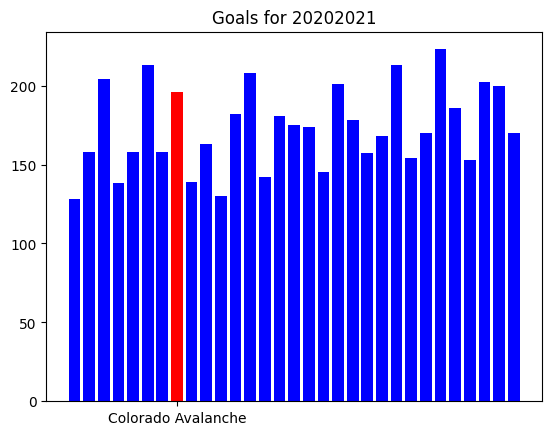

In [74]:
index = goals.loc[20202021].index
count_goals = goals.loc[20202021].values
plt.bar(range(len(index)), count_goals, color=colors)
plt.title('Goals for 20202021')
plt.xticks([a], [str(team)])
plt.show()

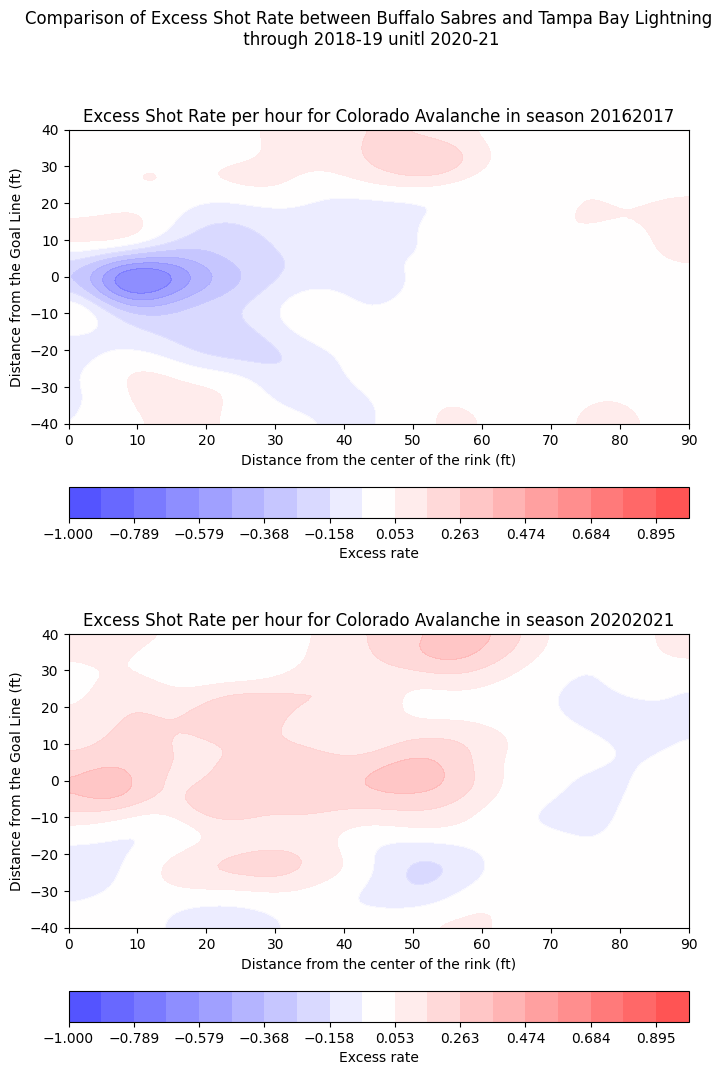

In [75]:
x = np.load('../data/x.npy')
y = np.load('../data/y.npy')
fig, axes = plt.subplots(2,1, figsize=(8, 12))


season = 20162017
loc = '../data/excess_{}.json'.format(season)
E = load_from_json(loc)
team_name = 'Colorado Avalanche' 
z = E[team_name]
im = axes[0].contourf(x, y, z, alpha = 0.7, cmap='bwr', levels = np.linspace(-1,1,20), vmin=-1, vmax=1) 
cbar = plt.colorbar(im, orientation = "horizontal", ax=axes[0], pad=0.15)
cbar.set_label('Excess rate' )
axes[0].set_xlabel('Distance from the center of the rink (ft)')
axes[0].set_ylabel('Distance from the Goal Line (ft)') 
axes[0].set_title(f'Excess Shot Rate per hour for {team_name} in season {season}')


season = 20202021
loc = '../data/excess_{}.json'.format(season)
E = load_from_json(loc)
team_name = 'Colorado Avalanche' 
z = E[team_name]
im = axes[1].contourf(x, y, z, alpha = 0.7, cmap='bwr', levels = np.linspace(-1,1,20), vmin=-1, vmax=1) 
cbar = plt.colorbar(im, orientation = "horizontal", ax=axes[1], pad=0.15)
cbar.set_label('Excess rate' )
axes[1].set_xlabel('Distance from the center of the rink (ft)')
axes[1].set_ylabel('Distance from the Goal Line (ft)') 
axes[1].set_title(f'Excess Shot Rate per hour for {team_name} in season {season}')


plt.suptitle('Comparison of Excess Shot Rate between Buffalo Sabres and Tampa Bay Lightning\n through 2018-19 unitl 2020-21')
# plt.subplots_adjust(wspace=0.001, hspace=0.001)
plt.savefig('comparison of one team.png')
plt.show() 

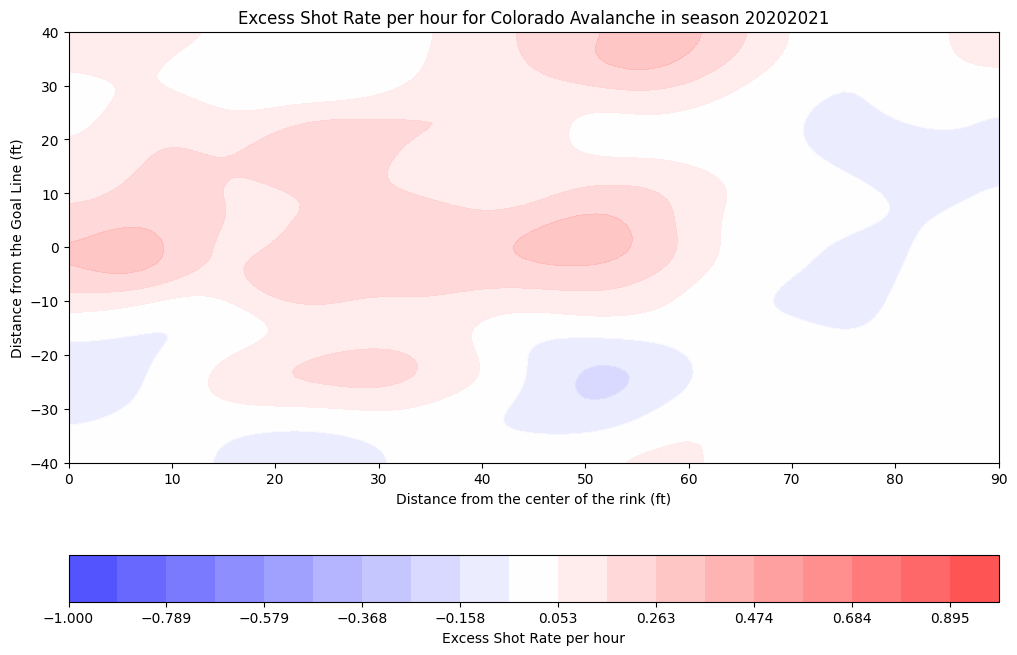

In [76]:
x = np.load('../data/x.npy')
y = np.load('../data/y.npy')

season = 20202021
loc = '../data/excess_{}.json'.format(season)
E = load_from_json(loc)
team_name = 'Colorado Avalanche' 
z = E[team_name]
plt.figure(figsize = [12, 8])
plt.contourf(x, y, z, alpha = 0.7, cmap='bwr', levels = np.linspace(-1,1,20), vmin=-1, vmax=1) 
plt.colorbar(orientation = "horizontal").set_label('Excess Shot Rate per hour')
plt.xlabel('Distance from the center of the rink (ft)')
plt.ylabel('Distance from the Goal Line (ft)') 
plt.title(f'Excess Shot Rate per hour for {team_name} in season {season}')
plt.savefig(f'Excess Shot Rate per hour for {team_name} in season {season}.png')
plt.show() 

## Question 6.4 
*Consider the Buffalo Sabres, which have been a team that has struggled over recent
years, and compare them to the Tampa Bay Lightning, a team which has won the
Stanley for two years in a row. Look at the shot maps for these two teams from the
2018-19, 2019-20, and 2020-21 seasons. Discuss what observations you can make. Is
there anything that could explain the Lightning’s success, or the Sabres’ struggles? How
complete of a picture do you think this pa*

**Answer**

Tampa Bay Lightning shot map shows a strategy pattern. They tend to start shooting from approx half way distance of their opponents net, devele into their defensive zone (mostly in a straight line manner). 

While Buffalo Sabres shows that they either shoot from far or close distances of the horizontal boarders, and have they less shots in front of the opponents net (not in stright line towards the opponents net). 


In summary, it's seems that the Tampa Bay Lightning key to success is more shots in the middle-center of the their offensive zone. While, While Buffalo Sabres has unsuccessful tries to shot from the horizontal boarder sides in distances either far or close from the net. 

Shooting from mostly in a stright line close to the net is more garanteed to be a gThis is also reflected in the conversion rate (how many shots tuned out to be goal) for Tampa Bay Lightning, Buffalo Sabres, all teams which are 11.4% and 8.9%. In addition, the reward-risk-ratio for Tampa Bay Lightning, Buffalo Sabres are 0.68 and 0.54 respectively. 
ints?

In [77]:
team_name_a = 'Buffalo Sabres' 
team_name_b = 'Tampa Bay Lightning'

In [78]:
seasons = [20182019, 20192020, 20202021] 
shots_a = {season:0 for season in seasons} 
shots_b = {season:0 for season in seasons} 
for season in seasons: 
    loc = '../data/excess_{}.json'.format(season)
    E = load_from_json(loc) 
    shots_a[season] = E[team_name_a]
    shots_b[season] = E[team_name_b]

In [79]:
subplot = lambda i,j, shots, year: axes[i, j].contourf(x, y, shots[year], alpha = 0.7, cmap='bwr', levels = np.linspace(-1,1,20), vmin=-1, vmax=1)

In [80]:
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib import gridspec

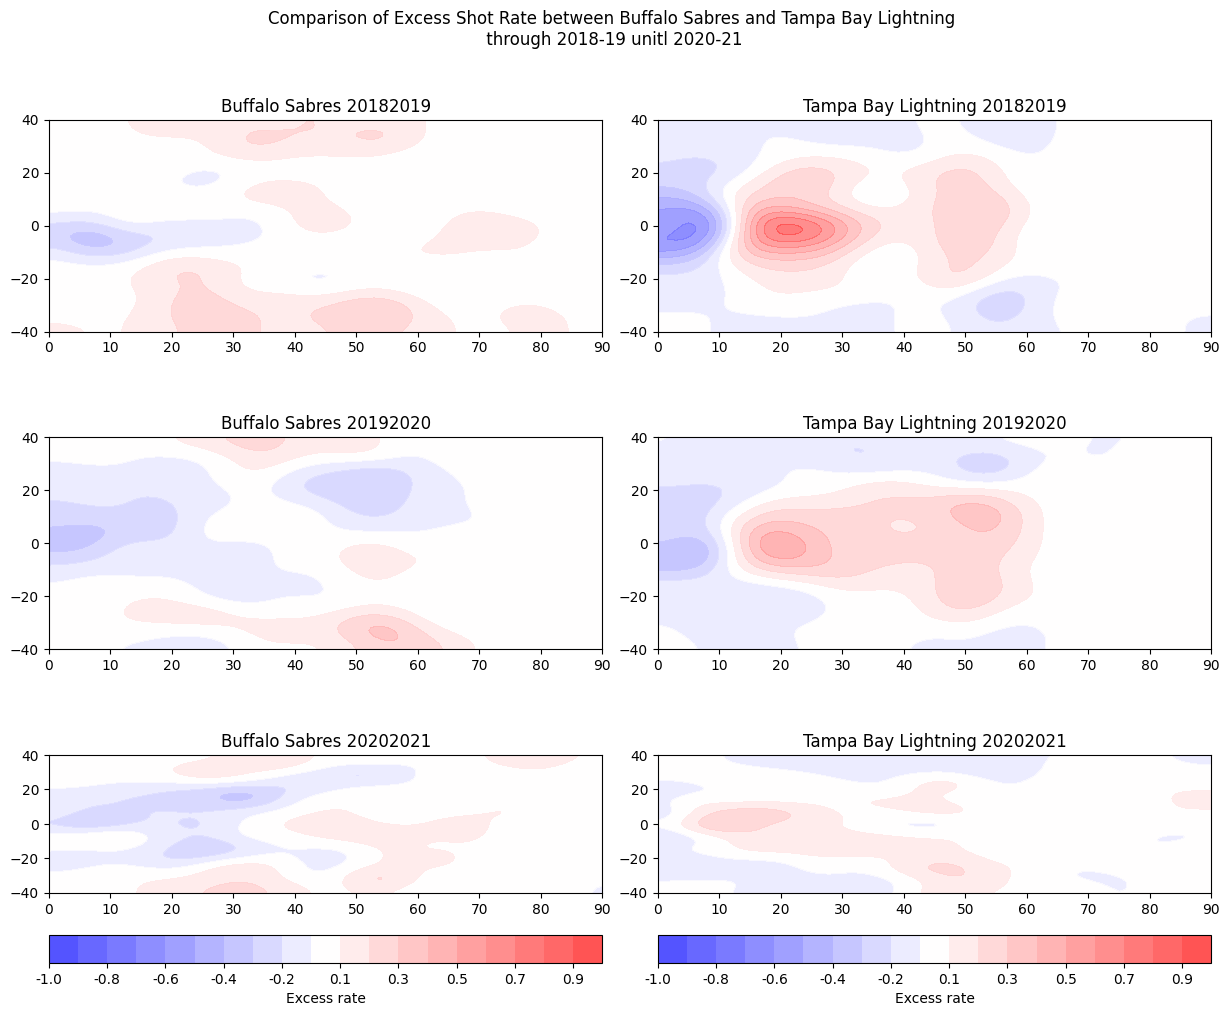

In [81]:
fig, axes = plt.subplots(3, 2, figsize=(15, 11))

im = subplot(0, 0, shots_a, 20182019) 
# cbar = plt.colorbar(im, orientation = "horizontal", ax=axes[0, 0], format="%.1f", pad=0.2)
# cbar.set_label('Excess rate' )
axes[0, 0].set_title('Buffalo Sabres 20182019')

im = subplot(1, 0, shots_a, 20192020) 
# cbar = plt.colorbar(im, orientation = "horizontal", ax=axes[1, 0], format="%.1f", pad=0.2)
# cbar.set_label('Excess rate' )
axes[1, 0].set_title('Buffalo Sabres 20192020')


im = subplot(2, 0, shots_a, 20202021) 
cbar = plt.colorbar(im, orientation = "horizontal", ax=axes[2, 0], format="%.1f", pad=0.2)
cbar.set_label('Excess rate' )
axes[2, 0].set_title('Buffalo Sabres 20202021')

##################

im = subplot(0, 1, shots_b, 20182019) 
# cbar = plt.colorbar(im, orientation = "horizontal", ax=axes[0, 1], format="%.1f", pad=0.2)
# cbar.set_label('Excess rate' )
axes[0, 1].set_title('Tampa Bay Lightning 20182019')

im = subplot(1, 1, shots_b, 20192020) 
# cbar = plt.colorbar(im, orientation = "horizontal", ax=axes[1, 1], format="%.1f", pad=0.2)
# cbar.set_label('Excess rate' )
axes[1, 1].set_title('Tampa Bay Lightning 20192020')

im = subplot(2, 1, shots_b, 20202021) 
cbar = plt.colorbar(im, orientation = "horizontal", ax=axes[2, 1], format="%.1f", pad=0.2)
cbar.set_label('Excess rate' )
axes[2, 1].set_title('Tampa Bay Lightning 20202021')

plt.suptitle('Comparison of Excess Shot Rate between Buffalo Sabres and Tampa Bay Lightning\n through 2018-19 unitl 2020-21')
plt.subplots_adjust(wspace=0.1, hspace=0.5)

plt.savefig('comparison of two teams.png')
plt.show()